In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import rv_continuous

In [30]:
def create_costs(mean, var):
    """create a cost function using scipy norm"""
    costs = rv_continuous()
    costs.pdf = lambda x: norm.pdf(x, loc=mean,scale=var)
    costs.cdf = lambda x: norm.cdf(x, loc=mean,scale=var)
    costs.rv =  lambda x: norm.rvs(loc=mean,scale=var,size=x)
    return costs


def gen_sims(value, reserve, nsims):
    """generate sims for monte carlo integration"""
    n = len(value)
    v_tile = np.repeat(value - reserve, nsims)
    r_tile = np.tile(reserve, n*nsims)
    sims = uniform.rvs(loc=r_tile, scale=v_tile)
    return sims.reshape(n,nsims)


def calc_bid(value, reserve, i, cost, nsims=20):
    """calculate bids based on value and reserve price"""
    value = np.maximum(value, reserve)
    sims = gen_sims(value, reserve, nsims)
    integral = (value-reserve)*(cost.cdf(sims)**(i-1)).mean(axis=1)
    bids =  value - integral/(cost.cdf(value))**(i-1)
    return bids


def sim_auction(reserve,i,n,cost,nsims=20):
    """simulate auction data"""
    values = cost.rvs(size=(i*n)) #clip rhs of distribution
    bids = calc_bid(values,reserve,i,cost,nsims)
    return values, bids
    

#values, bids = sim_auction(P,I, 100, COST,1000)

calc_bid([0.1,.2], 0, 4, COST, nsims=100)

array([0.02792588, 0.08165598])

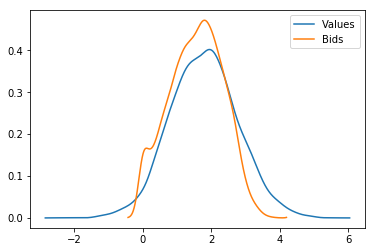

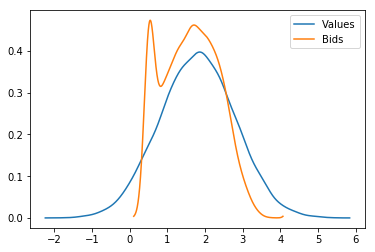

In [31]:
def graph_auction(reserve,i,n,cost,nsims=20):
    
    values, bids = sim_auction(reserve,i,n,cost,nsims=20)
    
    v_dens = sm.nonparametric.KDEUnivariate(values)
    v_dens.fit()
    plt.plot(v_dens.support, v_dens.density, label='Values')
    
    b_dens = sm.nonparametric.KDEUnivariate(bids)
    b_dens.fit()
    plt.plot(b_dens.support, b_dens.density, label='Bids') #.cdf does cdf
    
    plt.legend()
    plt.show()

    
P = .5
COST = create_costs(1.8,1)
I=7

graph_auction(0,I, 1000, COST, 1000)
graph_auction(.5,I, 1000, COST, 1000)

In [32]:
def calc_bid(value, reserve1, reserve2, i, cost, nsims=20):
    """calculate bids based on value and reserve price"""

